In [3]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

# of nodes :  34
# of edges :  78


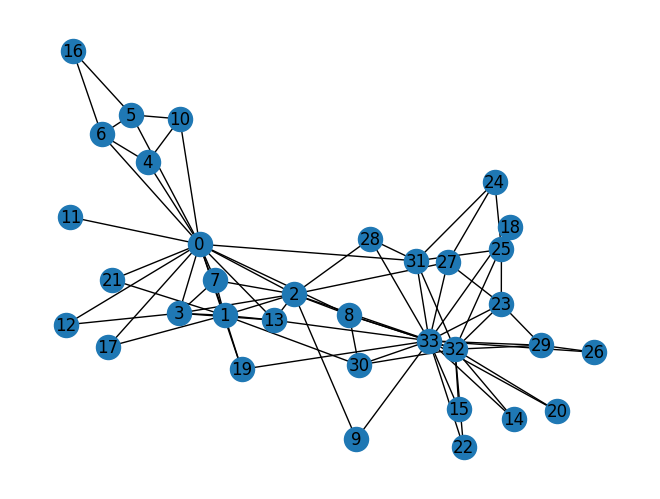

In [6]:
G = nx.karate_club_graph()
print('# of nodes : ', G.number_of_nodes())
print('# of edges : ', G.number_of_edges())
nx.draw(G, with_labels=True)
plt.show()

In [7]:
def random_walk(G, start_node, length):
    walk = [start_node]
    for _ in range(length):
        curr = walk[-1]
        neighbors = list(G.neighbors(curr))
        if neighbors:
            walk.append(random.choice(neighbors))
    return [str(node) for node in walk]

In [8]:
random_walk(G, 1, 5)

['1', '21', '0', '17', '1', '17']

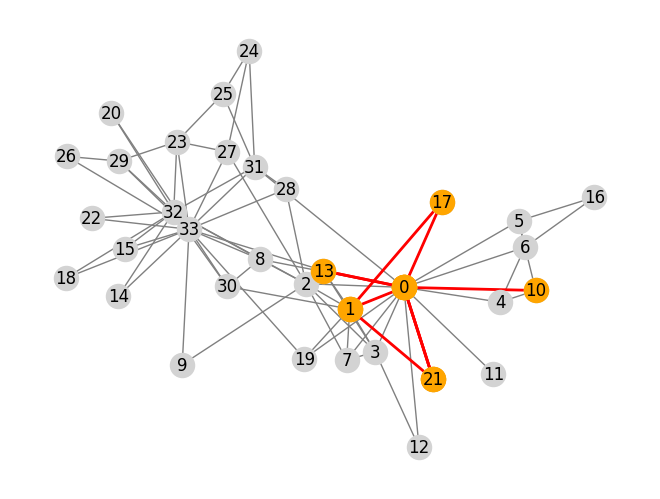

In [14]:
for i in range(5):
    random_path = [int(i) for i in random_walk(G, 1, 10)]
    random_edges = list(zip(random_path, random_path[1:]))
    
    # Draw base graph
    pos = nx.spring_layout(G)  # Layout for consistent positioning
    nx.draw(G, pos, with_labels=True, node_color='lightgray', edge_color='gray')
    
    # Highlight the path
    nx.draw_networkx_nodes(G, pos, nodelist=random_path, node_color='orange')
    nx.draw_networkx_edges(G, pos, edgelist=random_edges, edge_color='red', width=2)
    
    plt.show()

In [15]:
def deepwalk(G, length, num_walks, dim):
    walks = []
    nodes = list(G.nodes())

    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walk = random_walk(G, node, length)
            walks.append(walk)

    model = Word2Vec(walks, vector_size=dim, window=5, min_count=0, sg=1, workers=4)
    return model

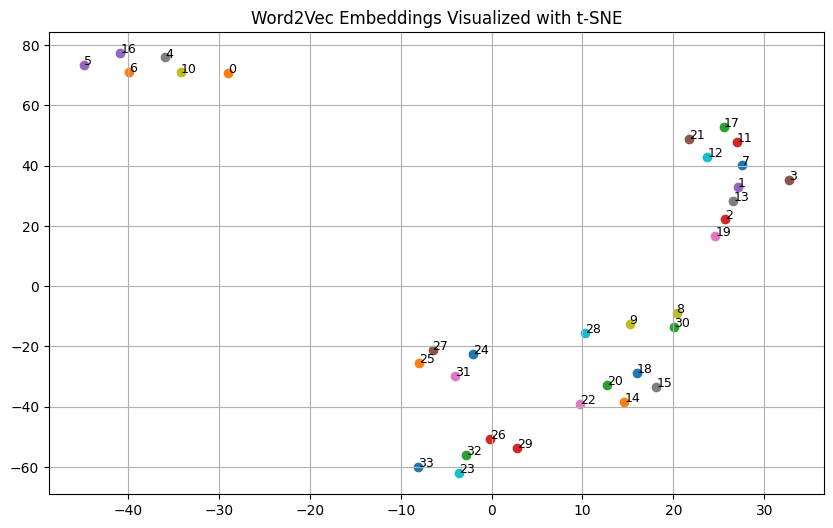

In [19]:
model = deepwalk(G, 20, 10, 128)

# Get word vectors and labels
words = list(model.wv.key_to_index)
word_vectors = model.wv[words]

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the embeddings
plt.figure(figsize=(10, 6))
for i, word in enumerate(words):
    x, y = word_vectors_2d[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), fontsize=9)
plt.title("Word2Vec Embeddings Visualized with t-SNE")
plt.grid(True)
plt.show()

In [20]:
def biased_random_walk(G, node, length, p, q): # node refers to a start node
    walk = [node]
    for _ in range(length):
        curr = walk[-1]
        prev = walk[-2] if len(walk) > 1 else None
        neighbors = list(G.neighbors(curr))
        if not neighbors:
            break
        if prev is None:
            walk.append(random.choice(neighbors))
        else:
            next_node = sample_next_node(G, curr, prev, neighbors, p, q)
            walk.append(next_node)
    return [str(node) for node in walk]

In [23]:
def sample_next_node(G, curr, prev, neighbors, p, q):
    if not neighbors:
        return None  # Dead end

    probs = []
    for neighbor in neighbors:
        if neighbor == prev:
            weight = 1 / p
        elif G.has_edge(neighbor, prev):
            weight = 1
        else:
            weight = 1 / q
        probs.append(weight)

    # Normalize probabilities
    total = sum(probs)
    probs = [w / total for w in probs]

    # Choose next node based on weighted probabilities
    next_node = random.choices(neighbors, weights=probs, k=1)[0]
    return next_node

In [24]:
def node2vec(G, length, num_walks, dim, p, q):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walk = biased_random_walk(G, node, length, p, q)
            walks.append(walk)
            
    model = Word2Vec(walks, vector_size=dim, window=5, min_count=0, sg=1, workers=4)
    return model

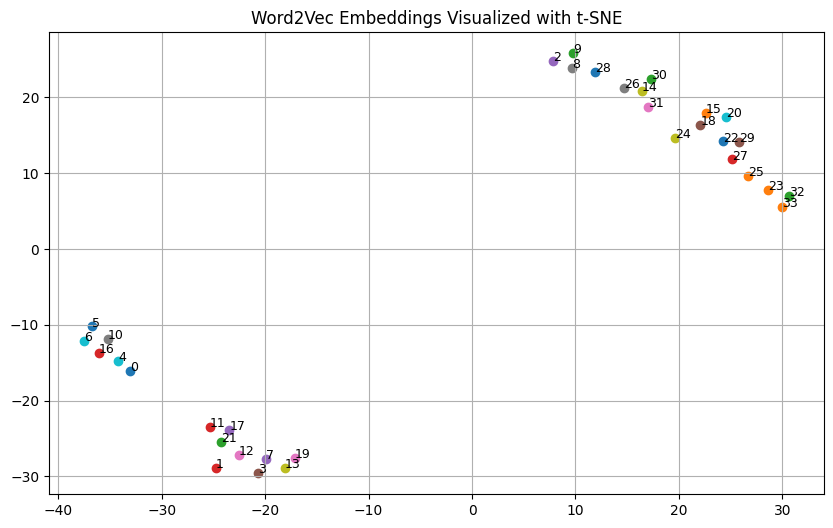

In [25]:
model = node2vec(G, 20, 10, 128, 2,1)

# Get word vectors and labels
words = list(model.wv.key_to_index)
word_vectors = model.wv[words]

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the embeddings
plt.figure(figsize=(10, 6))
for i, word in enumerate(words):
    x, y = word_vectors_2d[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), fontsize=9)
plt.title("Word2Vec Embeddings Visualized with t-SNE")
plt.grid(True)
plt.show()